# User Defined Equations

Examples:

- find value of evaporation temperature to achieve specific COP
- set the minimal pinch across a number of heat exchangers

## General info

- Formulate an equation $0 = ...$ in a custom function and return residual
- Specify which variables the equation depends on in a second function
- Pass all other relevant information to an instance of UserDefinedEquation
  - connections available through ude.conns
  - components available through ude.comps
  - function to calculate the partial derivatives explicitly instead of doing
    it via dependents
  - other parameters (dictionary) available through ude.params
- For more, readthedocs: https://tespy.readthedocs.io/en/main/modules/ude.html

## Specification of COP

- heat pump
- fixed efficiency of compressor
- fixed superheat and subcooling
- fixed evaporation and condensation temperature level
- target amount of heat production by condenser

In [1]:
from tespy.components import SimpleHeatExchanger, CycleCloser, Valve, Compressor
from tespy.connections import Connection
from tespy.networks import Network

In [2]:
nw = Network()
nw.units.set_defaults(
    temperature="°C",
    pressure="bar",
    power="kW"
)

In [3]:
evaporator = SimpleHeatExchanger("evaporator")
compressor = Compressor("compressor")
condenser = SimpleHeatExchanger("condenser")
valve = Valve("valve")
cc = CycleCloser("cc")

c1 = Connection(evaporator, "out1", compressor, "in1", label="c1")
c2 = Connection(compressor, "out1", condenser, "in1", label="c2")
c3 = Connection(condenser, "out1", valve, "in1", label="c3")
c4 = Connection(valve, "out1", cc, "in1", label="c4")
c5 = Connection(cc, "out1", evaporator, "in1", label="c5")

nw.add_conns(c1, c2, c3, c4, c5)

In [4]:
c1.set_attr(fluid={"R600": 1}, T_dew=10, td_dew=10)
c3.set_attr(T_bubble=60, td_bubble=5)

evaporator.set_attr(dp=0)
condenser.set_attr(dp=0, Q=-100)
compressor.set_attr(eta_s=0.8)

nw.solve("design")


 iter  | residual   | progress   | massflow   | pressure   | enthalpy   | fluid      | component  
-------+------------+------------+------------+------------+------------+------------+------------
 1     | 6.10e+05   | 2 %        | 1.78e+00   | 0.00e+00   | 6.39e+03   | 0.00e+00   | 0.00e+00   
 2     | 1.14e+04   | 21 %       | 3.19e-02   | 0.00e+00   | 1.18e-10   | 0.00e+00   | 0.00e+00   
 3     | 1.48e-10   | 100 %      | 3.20e-16   | 0.00e+00   | 1.18e-10   | 0.00e+00   | 0.00e+00   
 4     | 9.46e-11   | 100 %      | 1.35e-20   | 0.00e+00   | 1.18e-10   | 0.00e+00   | 0.00e+00   
Total iterations: 4, Calculation time: 0.00 s, Iterations per second: 3323.54


In [5]:
from tespy.tools import UserDefinedEquation


c1.set_attr(T_dew=None)

def cop_ude(ude):
    c1, c2, c3 = ude.conns
    target_cop = ude.params["target_cop"]
    return target_cop - (c2.h.val_SI - c3.h.val_SI) / (c2.h.val_SI - c1.h.val_SI)

def cop_ude_dependents(ude):
    return [c.h for c in ude.conns]

cop = 5

myude = UserDefinedEquation(
    "cop ude",
    cop_ude,
    cop_ude_dependents,
    conns=[c1, c2, c3],
    params={"target_cop": cop}
)

nw.add_ude(myude)
nw.solve("design")


 iter  | residual   | progress   | massflow   | pressure   | enthalpy   | fluid      | component  
-------+------------+------------+------------+------------+------------+------------+------------
 1     | 2.41e-01   | 73 %       | 4.25e-07   | 1.17e+04   | 3.41e+03   | 0.00e+00   | 0.00e+00   
 2     | 1.26e+02   | 43 %       | 3.98e-08   | 1.86e+02   | 1.56e+02   | 0.00e+00   | 0.00e+00   
 3     | 1.52e-02   | 86 %       | 5.56e-11   | 1.69e+00   | 4.70e-01   | 0.00e+00   | 0.00e+00   
 4     | 1.47e-06   | 100 %      | 2.53e-16   | 8.05e-06   | 3.75e-06   | 0.00e+00   | 0.00e+00   
 5     | 5.82e-10   | 100 %      | 6.54e-19   | 1.88e-09   | 5.24e-10   | 0.00e+00   | 0.00e+00   
Total iterations: 5, Calculation time: 0.00 s, Iterations per second: 1164.63


In [6]:
c1.T.val

22.16262950447009

## Minimal pinch across heat exchangers

In [7]:
from tespy.components import HeatExchanger, Source, Sink


nw = Network()
nw.units.set_defaults(
    temperature="°C",
    pressure="bar",
    power="kW"
)

In [8]:
source_wh = Source("waste heat source")
sink_wh = Sink("waste heat to ambient")

source_working_fluid = Source("liquid inflow")
sink_working_fluid = Sink("gas outflow")

preheater = HeatExchanger("preheater")
evaporator = HeatExchanger("evaporator")
superheater = HeatExchanger("superheater")

c1 = Connection(source_working_fluid, "out1", preheater, "in2", label="c1")
c2 = Connection(preheater, "out2", evaporator, "in2", label="c2")
c3 = Connection(evaporator, "out2", superheater, "in2", label="c3")
c4 = Connection(superheater, "out2", sink_working_fluid, "in1", label="c4")

b1 = Connection(source_wh, "out1", superheater, "in1", label="b1")
b2 = Connection(superheater, "out1", evaporator, "in1", label="b2")
b3 = Connection(evaporator, "out1", preheater, "in1", label="b3")
b4 = Connection(preheater, "out1", sink_wh, "in1", label="b4")

nw.add_conns(c1, c2, c3, c4, b1, b2, b3, b4)

In [9]:
c1.set_attr(fluid={"Isopentane": 1}, T=50, T_bubble=100)
c2.set_attr(x=0)
c3.set_attr(x=1)
c4.set_attr(td_dew=40)

b1.set_attr(fluid={"air": 1}, p=1, T=150, m=5)
b4.set_attr(T=100)

preheater.set_attr(dp1=0, dp2=0)
evaporator.set_attr(dp1=0, dp2=0)
superheater.set_attr(dp1=0, dp2=0)

nw.solve("design")


 iter  | residual   | progress   | massflow   | pressure   | enthalpy   | fluid      | component  
-------+------------+------------+------------+------------+------------+------------+------------
 1     | 2.25e+06   | 0 %        | 1.35e+00   | 0.00e+00   | 4.31e+05   | 0.00e+00   | 0.00e+00   
 2     | 3.25e-02   | 83 %       | 6.68e-08   | 0.00e+00   | 4.86e-03   | 0.00e+00   | 0.00e+00   
 3     | 2.06e-09   | 100 %      | 4.42e-17   | 0.00e+00   | 2.59e-10   | 0.00e+00   | 0.00e+00   
 4     | 1.81e-09   | 100 %      | 4.42e-17   | 0.00e+00   | 2.49e-10   | 0.00e+00   | 0.00e+00   
Total iterations: 4, Calculation time: 0.00 s, Iterations per second: 1521.74


In [10]:
from fluprodia import FluidPropertyDiagram
import matplotlib.pyplot as plt


diagram = FluidPropertyDiagram("Isopentane")
diagram.set_unit_system(T="°C", p="bar")
diagram.set_isolines_subcritical(0, 250)
diagram.calc_isolines()

In [11]:
from tespy.tools import get_plotting_data


processes, points = get_plotting_data(nw, "c1")
processes = {
    key: diagram.calc_individual_isoline(**value)
    for key, value in processes.items()
    if value is not None
}


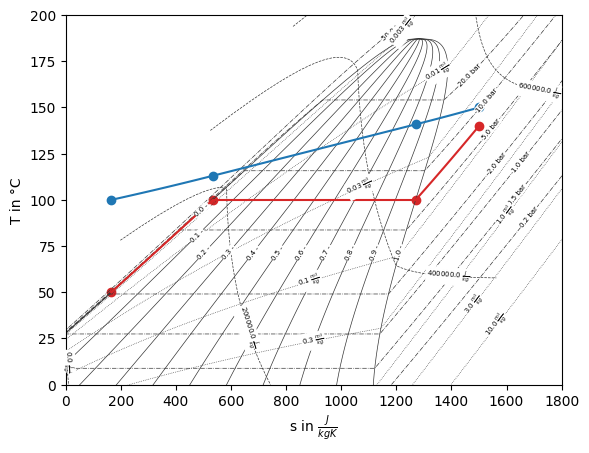

In [12]:
fig, ax = plt.subplots(1)
diagram.draw_isolines(fig, ax, "Ts", 0, 1800, 0, 200)

for label, values in processes.items():
    _ = ax.plot(values["s"], values["T"], label=label, color="tab:red")

for label, point in points.items():
    _ = ax.scatter(point["s"], point["T"], label=label, color="tab:red")


from tespy.tools.plotting import get_heatexchanger_secondary_Ts


other_processes, other_points = get_heatexchanger_secondary_Ts(nw, "c1")
for data in other_processes.values():
    for label, values in data.items():
        _ = ax.plot(values["s"], values["T"], label=label, color="tab:blue")

for data in other_points.values():
    for label, point in data.items():
        _ = ax.scatter(point["s"], point["T"], label=label, color="tab:blue")


In [13]:
def get_conn_list(heat_exchangers):
    # iterate from superheater to preheater (b1, b2, b3, b4)
    # this does not universally work!
    hot_side_conns = [
        heat_exchanger.inl[0] for heat_exchanger in heat_exchangers[::-1]
    ] + [heat_exchangers[0].outl[0]]
    # same here but take cross over connections (c4, c3, c2, c1)
    cold_side_conns = [
        heat_exchanger.outl[1] for heat_exchanger in heat_exchangers[::-1]
    ] + [heat_exchangers[0].inl[1]]
    return hot_side_conns, cold_side_conns


def pinch_ude(ude):
    pinch = ude.params["pinch"]
    heat_exchangers = ude.params["heat_exchanger_list"]
    hot_side_conns, cold_side_conns = get_conn_list(heat_exchangers)

    ttd_list = []
    for hsc, csc in zip(hot_side_conns, cold_side_conns):
        ttd_list += [hsc.calc_T() - csc.calc_T()]

    return pinch - min(ttd_list)

def pinch_ude_dependents(ude):
    heat_exchangers = ude.params["heat_exchanger_list"]
    hot_side_conns, cold_side_conns = get_conn_list(heat_exchangers)
    return [var for c in hot_side_conns + cold_side_conns for var in [c.p, c.h]]


from tespy.tools import UserDefinedEquation

ude = UserDefinedEquation(
    "minimum pinch equation",
    func=pinch_ude,
    dependents=pinch_ude_dependents,
    conns=[],
    params={"pinch": 5, "heat_exchanger_list": [preheater, evaporator, superheater]}
)

c1.set_attr(T_bubble=None)
nw.add_ude(ude)

nw.solve("design")


 iter  | residual   | progress   | massflow   | pressure   | enthalpy   | fluid      | component  
-------+------------+------------+------------+------------+------------+------------+------------
 1     | 5.00e+00   | 58 %       | 9.60e-03   | 7.78e+04   | 1.83e+04   | 0.00e+00   | 0.00e+00   
 2     | 3.92e+02   | 37 %       | 1.76e-04   | 3.15e+03   | 5.98e+02   | 0.00e+00   | 0.00e+00   
 3     | 2.91e-01   | 72 %       | 1.63e-07   | 4.61e+00   | 8.87e-01   | 0.00e+00   | 0.00e+00   
 4     | 6.88e-07   | 100 %      | 5.87e-13   | 6.77e-06   | 1.44e-06   | 0.00e+00   | 0.00e+00   
 5     | 2.63e-09   | 100 %      | 5.94e-16   | 9.57e-10   | 5.94e-10   | 0.00e+00   | 0.00e+00   
Total iterations: 5, Calculation time: 0.02 s, Iterations per second: 234.89


In [14]:
nw.print_results()


##### RESULTS (HeatExchanger) #####
+-------------+-----------+----------+----------+----------+----------+-----------+----------+----------+----------+----------+----------+----------+------------+-----------+-----------+
|             |         Q |       kA |   td_log |    ttd_u |    ttd_l |   ttd_min |      pr1 |      pr2 |      dp1 |      dp2 |    zeta1 |    zeta2 |   eff_cold |   eff_hot |   eff_max |
|-------------+-----------+----------+----------+----------+----------+-----------+----------+----------+----------+----------+----------+----------+------------+-----------+-----------|
| evaporator  | -1.35e+05 | 6.92e+03 | 1.96e+01 | 3.59e+01 | 9.17e+00 |  9.17e+00 | 1.00e+00 | 1.00e+00 | 0.00e+00 | 0.00e+00 | 0.00e+00 | 0.00e+00 |   7.65e-01 |  7.45e-01 |  7.65e-01 |
| preheater   | -7.17e+04 | 2.98e+03 | 2.41e+01 | 9.17e+00 | 5.00e+01 |  9.17e+00 | 1.00e+00 | 1.00e+00 | 0.00e+00 | 0.00e+00 | 0.00e+00 | 0.00e+00 |   3.29e-01 |  2.21e-01 |  3.29e-01 |
| superheater | -4.64e+04 | 

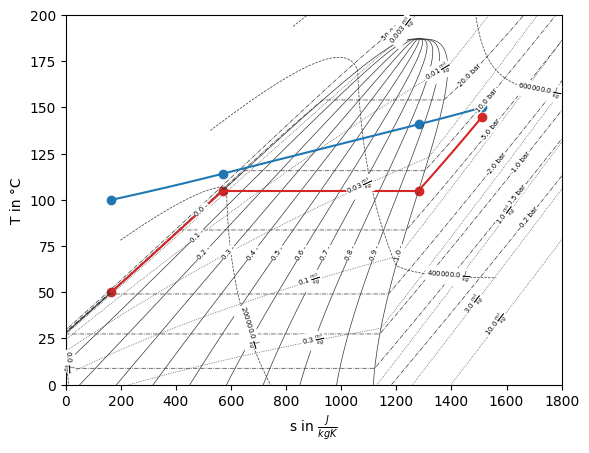

In [15]:
processes, points = get_plotting_data(nw, "c1")
processes = {
    key: diagram.calc_individual_isoline(**value)
    for key, value in processes.items()
    if value is not None
}
other_processes, other_points = get_heatexchanger_secondary_Ts(nw, "c1")

fig, ax = plt.subplots(1)
diagram.draw_isolines(fig, ax, "Ts", 0, 1800, 0, 200)

for label, values in processes.items():
    _ = ax.plot(values["s"], values["T"], label=label, color="tab:red")

for label, point in points.items():
    _ = ax.scatter(point["s"], point["T"], label=label, color="tab:red")

for data in other_processes.values():
    for label, values in data.items():
        _ = ax.plot(values["s"], values["T"], label=label, color="tab:blue")

for data in other_points.values():
    for label, point in data.items():
        _ = ax.scatter(point["s"], point["T"], label=label, color="tab:blue")